# Stochastic Gradient Fisher Scoring

*Example Notebook* for using Stochastic Gradient Fisher Scoring Step Method - It is based on [this](https://github.com/ferrine/pymc3/blob/a62b4fa98e75c392e634546d29cd5f2266007c46/docs/source/notebooks/simple_stochastic_optimization.ipynb)

The goal here is to learn from small noisy samples of a quadratic function and estimate the parameters of the function.

In [1]:
%matplotlib inline
import functools
import numpy as np
from theano import theano, tensor as tt
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3_experimental as pmexp
np.random.seed(42)

### Quadratic problem
Consider a simple quadratic problem with unknown parameters. 

In [2]:
def f(x, a, b, c):
    return a*x**2 + b*x + c

a, b, c = 1, 2, 3
min_ = np.array([-b/2/a])

### True data
Generate the quadaratic data with noise

/home/vaibhav/anaconda2/envs/pymc3/lib/python3.7/site-packages/pymc3-3.6-py3.7.egg/pymc3/data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
INFO (theano.gof.compilelock): Waiting for existing lock by process '18441' (I am process '18016')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/vaibhav/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.2-64/lock_dir
/home/vaibhav/anaconda2/envs/pymc3/lib/python3.7/site-packages/pymc3-3.6-py3.7.egg/pymc3/data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error

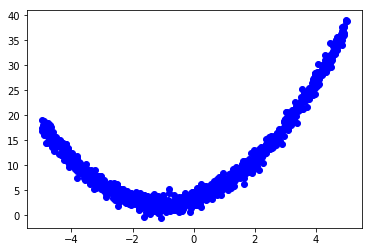

In [3]:
batch_size = 10
total_size = batch_size*100
def xy_obs_generator(batch_size):
    while True:
        x_obs = np.random.uniform(-5, 5, size=(batch_size,)).astype('float32')
        result = np.asarray([x_obs, f(x_obs, a, b, c) + np.random.normal(size=x_obs.shape).astype('float32')])
        yield result

x_train = np.random.uniform(-5, 5, size=(total_size,)).astype('float32')
x_obs = pm.Minibatch(x_train, batch_size=batch_size)

# xy_obs = pm.generator(xy_obs_generator(batch_size))
y_train = f(x_train, a, b, c) + np.random.normal(size=x_train.shape).astype('float32')
y_obs = pm.Minibatch(y_train, batch_size=batch_size)

# Example observation
# obs = xy_obs.eval()
plt.plot(x_train, y_train, 'bo');

### Final task
Our task is to find to estimate the quadratic function. We will test this by calculating L2 loss of the generated samples from the trained model to the observed output

/home/vaibhav/anaconda2/envs/pymc3/lib/python3.7/site-packages/pymc3-3.6-py3.7.egg/pymc3/step_methods/sgmcmc.py:110: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
Multiprocess sampling (2 chains in 2 jobs)
SGFS: [abc]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1813.85draws/s]
/home/vaibhav/anaconda2/envs/pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


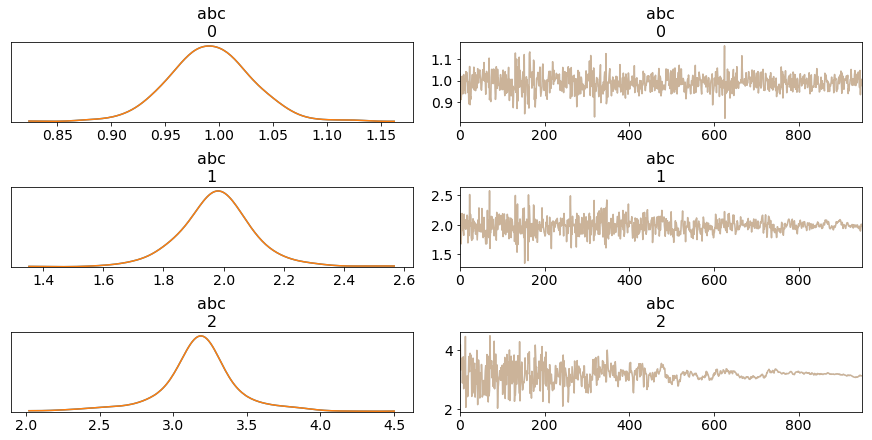

In [4]:
burn_in = 50
draws = 1000

with pm.Model() as model:
    abc = pm.Normal('abc', sigma=1, mu=1, shape=(3,))
    x = x_obs
    x2 = x**2
    o = tt.ones_like(x)
    X = tt.stack([x2, x, o]).T
    y = X.dot(abc)
    pm.Normal('y', mu=y, observed=y_obs, total_size=total_size)

    step_method = pmexp.SGFS(batch_size=batch_size, step_size=1.0, total_size=total_size)
    trace = pm.sample(draws=draws, step=step_method, init=None) 

pm.traceplot(trace[burn_in:]);

### Inference results

We don't have exact function as our observations were noisy

In [5]:
trace['abc'].mean(axis=0)

array([0.99154895, 1.98035615, 3.16397695])